# BIG DATA CW2 - SVHN Digit Classification Using a CNN 
---
**student ID'S**: Mike Shier **(UP2127137)**, Jack Elliott **(UP2119254)** and 

**Dataset**: SVHN (Street View House Numbers)

**Main Objectives**: Classifing digits from (0-9) from a 32 x 32RGB image using a loaded CNN Model. 

---

 ## Step - (1): Data Collection Downloaded from Urls on the SVHN Website

 Using the SVHN dataset the .mat files for training and testing were correctly downloaded, the files being curently in MATLAB format hence the (.mat). Files are only being downloaded once to save time and bandwidth, 
 the files contain over 600,000 labled 32x32 pixle RGB images of digits 0-9 provided on Google Streetview.

In [1]:
import os
import urllib.request

In [2]:
# Creating a folder for the data to be handled
os.makedirs("data", exist_ok= True)

In [3]:
# Defining the URLs for training and testing the data
urls = {
    "train":"http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
    "test":"http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
}

In [4]:
# Downloading functions
def download_svhn():
    for name, url in urls.items():
        filepath = f"data/{name}_32x32.mat"
        if not os.path.exists(filepath):
            print(f"downloading {name}data...")
            urllib.request.urlretrieve(url,filepath)
            print(f"{name.capitalize()}data download sucessfully.")
        else:
            print(f"{name.capitalize()} data already exists.")

download_svhn()



downloading traindata...
Traindata download sucessfully.
downloading testdata...
Testdata download sucessfully.


# Step - (2): Preprocess the SVHN Dataset

This loads the .mat files downloaded in step 1 and converts the data presented into the correct format, normalizing the pixel values to [0, 1], fixing the label format to (10-0), and correctly splits the training set into 80% training and 20% validation using satisfied sampeling.  
 

In [10]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
# Loading the data 
train_data = scipy.io.loadmat("data/train_32x32.mat")
test_data = scipy.io.loadmat("data/test_32x32.mat")

In [12]:
# Transposing image arrays to the correct shape: e.g.(32,32,3)
X_train = np.transpose(train_data['X'], (3, 0, 1, 2))
y_train = train_data['y'].flatten()


X_test = np.transpose(test_data['X'], (3, 0, 1, 2))
y_test = train_data['y'].flatten()


In [13]:
# Replace Label '10' with '0'
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [14]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [15]:
# Spitting training sets: 80% training, 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train, random_state = 42)

In [16]:
# Printing Shapes
print("Train set shape:", X_train_split.shape, y_train_split.shape)
print("Validation set shape:", X_val_split.shape, y_val_split.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Train set shape: (58605, 32, 32, 3) (58605,)
Validation set shape: (14652, 32, 32, 3) (14652,)
Testing set shape: (26032, 32, 32, 3) (73257,)


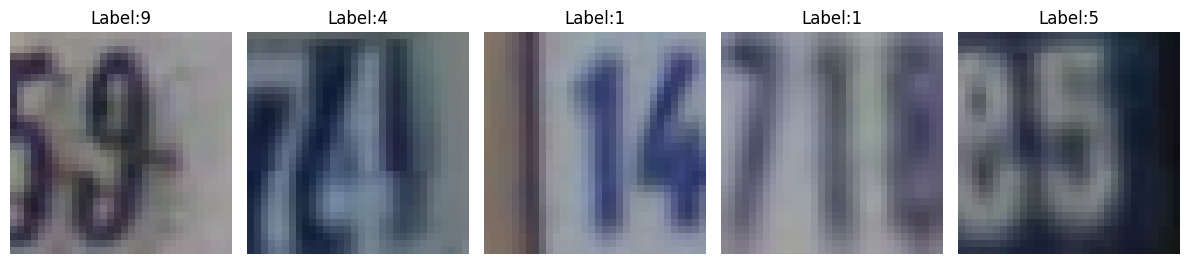

In [20]:
# Visulising some samples 
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(X_train_split[i])
    axes[i].set_title(f"Label:{y_train_split[i]}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()
    